In [3]:
import numpy as np
from matplotlib import pyplot as plt
from urllib import request
import gzip
import pandas as pd
from os import path
from scipy.fft import fft, fftshift, fftfreq

## An attempt to streamline/automate stuff from other notebooks
 * gave up?

In [6]:
tau0 = 30.0


def find_line_containing(file, the_string) -> int:
    for num, line in enumerate(file, 1):
        if the_string in line:
            return num


def convert_time(row, day):
    return (
        row["Day"] * 24.0 * 60.0 * 60.0
        + row["Hour"] * 60.0 * 60.0
        + row["Minute"] * 60.0
        + row["Second"]
        - day * 24.0 * 60.0 * 60.0
    )


def get_weighted_av_data(week, day_of_week):
    url = "https://sideshow.jpl.nasa.gov/pub/jpligsac/" + str(week) + "/"
    filename = "jpl" + str(week) + str(day_of_week) + ".clk.gz"
    dpath = "jpligsac/"

    # Download the file (if we don't have it already)
    if not path.isfile(dpath + filename):
        downloaded_file, info = request.urlretrieve(
            url + filename,
            dpath + filename,
        )
        assert downloaded_file == dpath + filename

    # Unip the file, and "read" as "text" to search for the string
    unziped = gzip.open(dpath + filename, "rt")
    header_line = find_line_containing(unziped, "END OF HEADER")
    print(f"Read JPL {week}:{day_of_week}")

    return parse_data(dpath + filename, header_line)


def parse_data(filename, header_line):
    data = pd.read_csv(
        filename,
        skiprows=header_line,
        delimiter=" ",
        skipinitialspace=True,  # Interpret multiple spaces as 1 delimiter
        names=(  # Optional: give meaningful names to each column of data file:
            "Type",
            "Clock",
            "Year",
            "Month",
            "Day",
            "Hour",
            "Minute",
            "Second",
            "ncols",
            "Bias",
            "Error",
        ),
    )
    clock_list = np.sort(data[data.Type == "AS"]["Clock"].unique())
    keywords = {"day": data["Day"].iloc[0]}
    data["Time"] = data.apply(convert_time, axis=1, **keywords)
    sat_data = data[data.Type == "AS"]
    dws = [
        np.diff(sat_data[sat_data.Clock == clock]["Bias"]) / tau0
        for clock in clock_list
    ]
    sigmas = [np.std(dw) for dw in dws]
    # t = sat_data[sat_data.Clock == clock_list[0]]["Time"][:-1].to_numpy()
    # choose only full days!
    # assert len(t) == 2880

    dw_av = 0.0 * dws[0]
    w = 0.0
    for i in range(len(dws)):
        # Only include clocks will no data gaps
        if dws[i].size != 2880:
            continue
        dw_av += (dws[i] - np.mean(dws[i])) / (sigmas[i] ** 2)
        w += 1.0 / (sigmas[i] ** 2)
    dw_av /= w

    return dw_av


def AmpSpec(dw):
    ft = fftshift(fft(dw))
    return 2.0 * np.abs(ft) / dw.size

## Read data for multiple days

Read JPL 2310:0
Read JPL 2310:1
Read JPL 2310:2
Read JPL 2310:3
Read JPL 2310:4
Read JPL 2310:5
Read JPL 2310:6


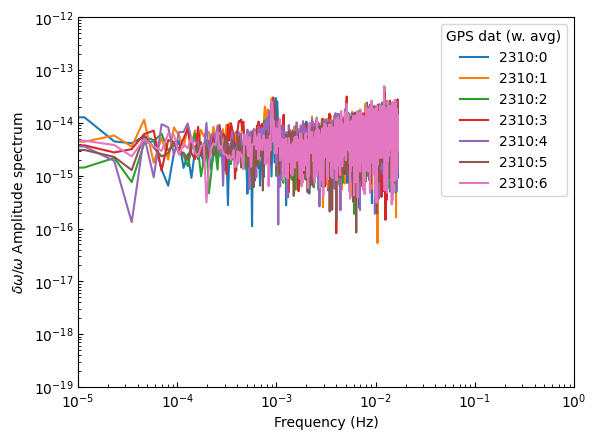

In [7]:
freq = fftshift(fftfreq(2880, d=tau0))

week = 2310
for week, day in [[week, day] for week in range(2310, 2311) for day in range(7)]:
    dw = get_weighted_av_data(week, day)
    amp = AmpSpec(dw)
    plt.plot(freq, amp, label=f"{week}:{day}")

plt.xlabel("Frequency (Hz)")
plt.ylabel("$\\delta\\omega/\\omega$ Amplitude spectrum")
plt.xlim(1e-5, 1)
plt.ylim(1e-19, 1e-12)
plt.xscale("log")
plt.yscale("log")
plt.legend(title="GPS dat (w. avg)")
plt.tick_params(direction="in", which="both")
plt.show()